In [1]:
# Import basic dependencies for PyTorch

from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Define the transformations we want. This is because the image we get is just a scrub PIL image that we cant work with
transform = transforms.Compose([transforms.ToTensor()])

# Download the training and testing datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

tensor([4, 3, 0, 8])


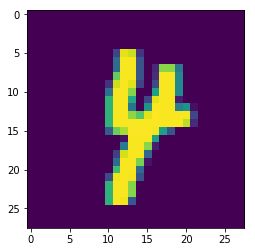

In [3]:
# Plot them just to see 
dataiter = iter(trainloader)
img, label = dataiter.next()

plt.imshow(img[0,0,:,:])
print (label)

In [5]:
# Define our neural network architecture here. It's a simple LeNet architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
net = Net()

In [6]:
# Define PyTorch optimizer here, along with the criteria we want to optimize for and 
# the optimizer (which is stochastic gradient descent)
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# Train our model here. Specify the number of epochs (loops over the dataset)
# Also, lets load stuff to the GPU

# Now lets load stuff onto the GPU and see how things go

import time
start_time = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')
print("--- %s seconds ---" % (time.time() - start_time))

cuda:0
[1,  2000] loss: 0.669
[1,  4000] loss: 0.176
[1,  6000] loss: 0.132
[1,  8000] loss: 0.111
[1, 10000] loss: 0.083
[1, 12000] loss: 0.082
[1, 14000] loss: 0.079
[2,  2000] loss: 0.052
[2,  4000] loss: 0.057
[2,  6000] loss: 0.051
[2,  8000] loss: 0.052
[2, 10000] loss: 0.053
[2, 12000] loss: 0.052
[2, 14000] loss: 0.046
Finished Training
--- 47.54809236526489 seconds ---


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 98.860000 %


In [48]:
# Sanity check to see if we're all good
incorrect_images = []

with torch.no_grad():
    for data in testloader:
        images,labels = data
        images,labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        diff = torch.nonzero(predicted != labels)
        if (len(diff) > 0):
            idx = diff[0]
#             print (idx)
            incorrect_images.append(images[idx])

# dataiter = iter(testloader)
# img, label = dataiter.next()
# # print (label)
# outputs = net(img)
# print (torch.max(outputs.data, 1)[1])

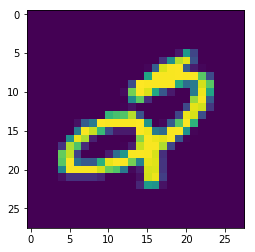

In [55]:
# Plot the incorrect images
img = incorrect_images[i].cpu()
plt.figure()
plt.imshow(img[0,0,:,:].numpy())

In [57]:
# Save the PyTorch model
torch.save({'state_dict': net.state_dict()}, 'checkpoint.pth.tar')

In [62]:
# Reload the PyTorch model; to do this we'll need the 
model = Net()
checkpoint = torch.load('checkpoint.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.to(device)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 98.860000 %


In [ ]:
# CPU stuff - you can ignore this
import time
start_time = time.time()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics of training everything here
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')
print("--- %s seconds ---" % (time.time() - start_time))